# 车杆平衡 CartPole-v0

In [1]:
%matplotlib inline
import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import tensorflow as tf
from tensorflow import keras
try: # tf2
    tf.random.set_seed(0)
    from tensorflow.keras.initializers import GlorotUniform
except: # tf1
    tf.random.set_random_seed(0)
    from tensorflow import glorot_uniform_initializer as GlorotUniform
import matplotlib.pyplot as plt

In [2]:
env = gym.make('CartPole-v0')
env.seed(0)

[0]

### 用简单策略梯度算法寻找最优策略

In [3]:
class VPGAgent:
    def __init__(self, env, policy_kwargs, baseline_kwargs=None,
            gamma=0.99):
        self.action_n = env.action_space.n
        self.gamma = gamma
        
        self.trajectory = []

        self.policy_net = self.build_network(output_size=self.action_n,
                output_activation=tf.nn.softmax,
                loss=keras.losses.categorical_crossentropy,
                **policy_kwargs)
        if baseline_kwargs:
            self.baseline_net = self.build_network(output_size=1,
                    **baseline_kwargs)
    
    def build_network(self, hidden_sizes, output_size,
                activation=tf.nn.relu, output_activation=None,
                loss=keras.losses.mse, learning_rate=0.01):
        model = keras.Sequential()
        for hidden_size in hidden_sizes:
            model.add(keras.layers.Dense(units=hidden_size,
                    activation=activation,
                    kernel_initializer=GlorotUniform(seed=0)))
        model.add(keras.layers.Dense(units=output_size,
                activation=output_activation,
                kernel_initializer=GlorotUniform(seed=0)))
        optimizer = keras.optimizers.Adam(learning_rate)
        model.compile(optimizer=optimizer, loss=loss)
        return model
      
    def decide(self, observation):
        probs = self.policy_net.predict(observation[np.newaxis])[0]
        action = np.random.choice(self.action_n, p=probs)
        return action
        
    def learn(self, observation, action, reward, done):
        self.trajectory.append((observation, action, reward))

        if done:
            df = pd.DataFrame(self.trajectory,
                    columns=['observation', 'action', 'reward'])
            df['discount'] = self.gamma ** df.index.to_series()
            df['discounted_reward'] = df['discount'] * df['reward']
            df['discounted_return'] = df['discounted_reward'][::-1].cumsum()
            df['psi'] = df['discounted_return']
            
            x = np.stack(df['observation'])
            if hasattr(self, 'baseline_net'):
                df['baseline'] = self.baseline_net.predict(x)
                df['psi'] -= (df['baseline'] * df['discount'])
                df['return'] = df['discounted_return'] / df['discount']
                y = df['return'].values[:, np.newaxis]
                self.baseline_net.fit(x, y, verbose=0)
            
            y = np.eye(self.action_n)[df['action']] * \
                    df['psi'].values[:, np.newaxis]
            self.policy_net.fit(x, y, verbose=0)
            
            self.trajectory = []

In [4]:
def play_montecarlo(env, agent, render=False, train=False):
    observation = env.reset()
    episode_reward = 0.
    while True:
        if render:
            env.render()
        action = agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if train:
            agent.learn(observation, action, reward, done)
        if done:
            break
        observation = next_observation
    return episode_reward

不带基线的简单策略梯度算法

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
平均回合奖励 = 18955.0 / 100 = 189.55


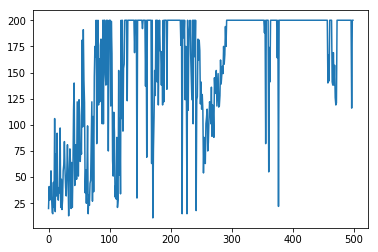

In [5]:
policy_kwargs = {'hidden_sizes' : [10,], 'activation' : tf.nn.relu,
        'learning_rate' : 0.01}
agent = VPGAgent(env, policy_kwargs=policy_kwargs)

# 训练
episodes = 500
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_montecarlo(env, agent, train=True)
    episode_rewards.append(episode_reward)
    
plt.plot(episode_rewards);

# 测试
episode_rewards = [play_montecarlo(env, agent)  for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

带基线的简单策略梯度算法

平均回合奖励 = 19695.0 / 100 = 196.95


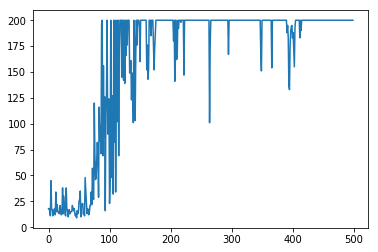

In [6]:
policy_kwargs = {'hidden_sizes' : [10,], 'activation':tf.nn.relu, 
        'learning_rate':0.01}
baseline_kwargs = {'hidden_sizes' : [10,], 'activation':tf.nn.relu,
        'learning_rate':0.01}
agent = VPGAgent(env, policy_kwargs=policy_kwargs,
        baseline_kwargs=baseline_kwargs)

# 训练
episodes = 500
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_montecarlo(env, agent, train=True)
    episode_rewards.append(episode_reward)
    
plt.plot(episode_rewards);

# 测试
episode_rewards = [play_montecarlo(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

### 异策策略梯度算法

In [7]:
class RandomAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        
    def decide(self, observation):
        action = np.random.choice(self.action_n)
        behavior = 1. / self.action_n
        return action, behavior


class OffPolicyVPGAgent(VPGAgent):
    def __init__(self, env, policy_kwargs, baseline_kwargs=None, 
            gamma=0.99):
        self.action_n = env.action_space.n
        self.gamma = gamma

        self.trajectory = []

        def dot(y_true, y_pred):
            return -tf.reduce_sum(y_true * y_pred, axis=-1)
        
        self.policy_net = self.build_network(output_size=self.action_n,
                output_activation=tf.nn.softmax, loss=dot, **policy_kwargs)
        if baseline_kwargs:
            self.baseline_net = self.build_network(output_size=1,
                    **baseline_kwargs)
    
    def learn(self, observation, action, behavior, reward, done):
        self.trajectory.append((observation, action, behavior, reward))

        if done:
            df = pd.DataFrame(self.trajectory, columns=
                    ['observation', 'action', 'behavior', 'reward'])
            df['discount'] = self.gamma ** df.index.to_series()
            df['discounted_reward'] = df['discount'] * df['reward']
            df['discounted_return'] = \
                    df['discounted_reward'][::-1].cumsum()
            df['psi'] = df['discounted_return']
            
            x = np.stack(df['observation'])
            if hasattr(self, 'baseline_net'):
                df['baseline'] = self.baseline_net.predict(x)
                df['psi'] -= df['baseline'] * df['discount']
                df['return'] = df['discounted_return'] / df['discount']
                y = df['return'].values[:, np.newaxis]
                self.baseline_net.fit(x, y, verbose=0)
                
            y = np.eye(self.action_n)[df['action']] * \
                    (df['psi'] / df['behavior']).values[:, np.newaxis]
            self.policy_net.fit(x, y, verbose=0)
            
            self.trajectory = []

不带基线的重要性采样策略梯度算法

平均回合奖励 = 9397.0 / 100 = 93.97


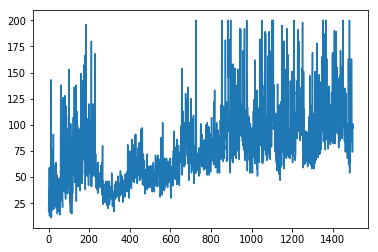

In [8]:
policy_kwargs = {'hidden_sizes' : [10,], 'activation':tf.nn.relu,
        'learning_rate':0.01}
agent = OffPolicyVPGAgent(env, policy_kwargs=policy_kwargs)
behavior_agent = RandomAgent(env)

# 训练
episodes = 1500
episode_rewards = []
for episode in range(episodes):
    observation = env.reset()
    episode_reward = 0.
    while True:
        action, behavior = behavior_agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        agent.learn(observation, action, behavior, reward, done)
        if done:
            break
        observation = next_observation
    
    # 跟踪监控
    episode_reward = play_montecarlo(env, agent)
    episode_rewards.append(episode_reward)

plt.plot(episode_rewards);

# 测试
episode_rewards = [play_montecarlo(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

带基线的重要性采样策略梯度算法

平均回合奖励 = 19571.0 / 100 = 195.71


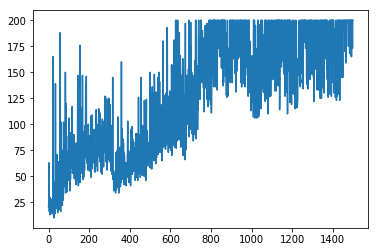

In [9]:
policy_kwargs = {'hidden_sizes' : [10,], 'activation':tf.nn.relu,
        'learning_rate':0.01}
baseline_kwargs = {'hidden_sizes' : [10,], 'activation':tf.nn.relu,
        'learning_rate':0.01}
agent = OffPolicyVPGAgent(env, policy_kwargs=policy_kwargs,
        baseline_kwargs=baseline_kwargs)
behavior_agent = RandomAgent(env)

# 训练
episodes = 1500
episode_rewards = []
for episode in range(episodes):
    observation = env.reset()
    episode_reward = 0.
    while True:
        action, behavior = behavior_agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        agent.learn(observation, action, behavior, reward, done)
        if done:
            break
        observation = next_observation
    
    # 跟踪监控
    episode_reward = play_montecarlo(env, agent)
    episode_rewards.append(episode_reward)

plt.plot(episode_rewards);

# 测试
episode_rewards = [play_montecarlo(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

In [10]:
env.close()